In [50]:
import os
import sys
import glob

import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from fastsnn import results

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
root = os.path.join(os.path.dirname(os.getcwd()), "results/benchmarks")

benchmark_query = results.BenchmarkQuery(root)
palette = [sns.color_palette("tab10")[i] for i in [9, 8, 1]]

## 2D speedup plot

In [13]:
def plot_contour(ax, x, y, z, z_min, z_max, fontscale=1, ylabel=None, title="", s=3):
    title_size = int(fontscale * 20)
    labelsize = int(fontscale * 20)
    ticksize = int(fontscale * 14)
    tickpad = int(fontscale * 10)
    labelpad = int(fontscale * 16)
    titlepad = int(fontscale * 15)
    edge_width = 0#3#int(fontscale * 2)
    
    colorbar = ax.tricontourf(x, y, z, levels=np.linspace(z_min, z_max, 100), cmap=plt.cm.RdBu)
    ax.scatter(x, y, c="gray", s=s)
    
    ax.spines["bottom"].set_linewidth(edge_width)
    ax.spines["top"].set_linewidth(edge_width)
    ax.spines["left"].set_linewidth(edge_width)
    ax.spines["right"].set_linewidth(edge_width)
    ax.xaxis.set_tick_params(width=edge_width)
    ax.yaxis.set_tick_params(width=edge_width)
    
    x_labels = [f"{int(v)}" for v in pd.Series(x).unique()]
    ax.set_yticks(list(pd.Series(y).unique()))
    ax.set_xticks(list(pd.Series(x).unique()))
    ax.set_xticklabels(x_labels)
    
    y_labels = [f"${v}$" for v in pd.Series(y).unique()]
    ax.set_yticklabels(y_labels)
    
    ax.tick_params(axis='both', which='major', labelsize=ticksize, pad=tickpad)
    
    # Title
    ax.set_title(title, fontsize=title_size, pad=titlepad)
    
    return colorbar

3.8740588284010435
5
-5.362156641130951
[-5, -4, -3, -2, -1, 0, 1, 2, 3, 3.8740588284010435]
[0.03, 0.06, 0.12, 0.25, 0.5, 1, 2, 4, 8, 14.66]


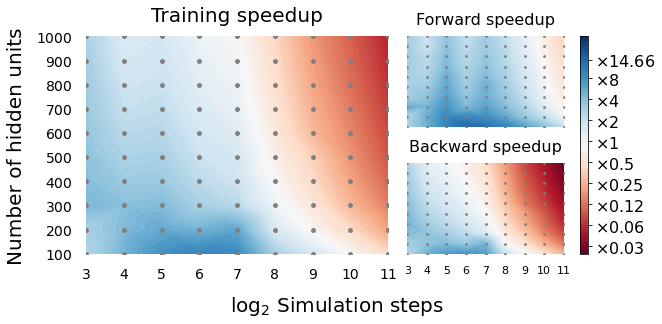

In [46]:
def plot_2d_speedups(fig, spec):
    
    def plot_2d_speedup(x, y, total_speedups, z_min, z_max, spec):
        ax = plt.Subplot(fig, spec)
        plot_contour(ax, x, y, total_speedups, z_min, z_max, ylabel="Number of units", title="Training speedup", s=15)
        fig.add_subplot(ax)
    
    def plot_2d_subspeedups(x, y, forward_speedups, backward_speedups, pass_speedups, z_min, z_max, spec):
        subspeedup_spec = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=spec, hspace=0.4)
        
        # 1. 
        ax = plt.Subplot(fig, subspeedup_spec[0, 0])
        plot_contour(ax, x, y, forward_speedups, z_min, z_max, fontscale=0.8, ylabel="", title="Forward speedup")
        # Disable x axis
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        fig.add_subplot(ax)
        
        # 2. 
        ax = plt.Subplot(fig, subspeedup_spec[1, 0])
        colorbar = plot_contour(ax, x, y, backward_speedups, z_min, z_max, fontscale=0.8, title="Backward speedup")
        ax.set_yticklabels([])
        fig.add_subplot(ax)
        
        return colorbar
       
    speedups_df = benchmark_query.get_speedups(batch=128)
    speedups_df = speedups_df.groupby(["units", "t_len"]).mean()
    multi_index = speedups_df.index
    x = [np.log2(index[1]) for index in multi_index]
    y = [index[0] for index in multi_index]
    forward_speedups = np.log2(speedups_df["forward_speedup"])
    backward_speedups = np.log2(speedups_df["backward_speedup"])
    total_speedups = np.log2(speedups_df["total_speedup"])
    pass_speedups = None
    
    acc_z_min = min([forward_speedups.min(), backward_speedups.min(), total_speedups.min()]) 
    acc_z_max = max([forward_speedups.max(), backward_speedups.max(), total_speedups.max()]) 
    
    z_min = acc_z_min
    z_max = 5#acc_z_max
    
    print(forward_speedups.max())
    print(z_max)
    print(z_min)
    
    speedup_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=spec, wspace=0.08, hspace=0.3, width_ratios=[1, 0.6])
    speedup_rigt_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=speedup_spec[0, 1], wspace=0.2, hspace=0.3, width_ratios=[0.95, 0.05])
    
    # Plot shared y label
    label_size = 20
    ax = fig.add_subplot(speedup_spec[0, 0])
    ax.set_ylabel("Number of hidden units", fontsize=label_size, labelpad=60)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot shared x label
    label_size = 20
    ax = fig.add_subplot(speedup_spec[0, :])
    ax.set_xlabel("$\\log_2$ Simulation steps", fontsize=label_size, labelpad=40)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot data
    plot_2d_speedup(x, y, total_speedups, z_min, z_max, speedup_spec[0, 0])
    colorbar = plot_2d_subspeedups(x, y, forward_speedups, backward_speedups, pass_speedups, z_min, z_max, speedup_rigt_spec[0, 0])
        
    # Plot colorbar
    cbar_ax = plt.Subplot(fig, speedup_rigt_spec[0, 1])
    fig.add_subplot(cbar_ax)
    cbar = fig.colorbar(colorbar, cbar_ax)
    
    cbarsize = 16
    cbarticksize = 16 #10
    cbartitle = "$\\times$ Speedup"
    cbar = fig.colorbar(colorbar, cbar_ax)
    
    ticks = [*list(range(round(z_min), round(z_max))), z_max]
    
    #ticks = [-6, 0, 1, 2, 3, 4, 5, 5.7]
    
    # Filter ticks
    ticks = ticks[:-2]
    ticks.append(acc_z_max)
    
    #del ticks[-2]
    
    cbar.set_ticks(ticks)
    print(ticks)
    print([round(2 ** e, 2) for e in ticks])
    cbar.set_ticklabels([f'$\\times {v}$' for v in [round(2 ** e, 2) for e in ticks]])
    cbar.ax.get_yaxis().labelpad = 10
    # cbar.ax.set_ylabel(cbartitle, fontsize=cbarsize)
    cbar.ax.tick_params(labelsize=cbarticksize)
     
fig = plt.figure(figsize=(9, 4))
fig_spec = gridspec.GridSpec(1, 1)
plot_2d_speedups(fig, fig_spec[0, 0])

## Plot duration

In [47]:
def plot(ax, xlabel, ylabel, title):
    title_size = 20
    label_size = 20
    line_width = 3
    edge_width = 3
    errwidth = 2
    
    ax.tick_params(axis='both', which='major', pad=5, labelsize=label_size) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=title_size, pad=17)
    
    # x-axis
    ax.spines["bottom"].set_linewidth(edge_width)
    ax.xaxis.set_tick_params(width=edge_width)
    ax.set_xlabel(xlabel, fontsize=label_size)
    
    # y-axis
    ax.spines["left"].set_linewidth(edge_width)
    ax.yaxis.set_tick_params(width=edge_width)
    ax.set_ylabel(ylabel, fontsize=label_size)
    
    ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
    
    return ax

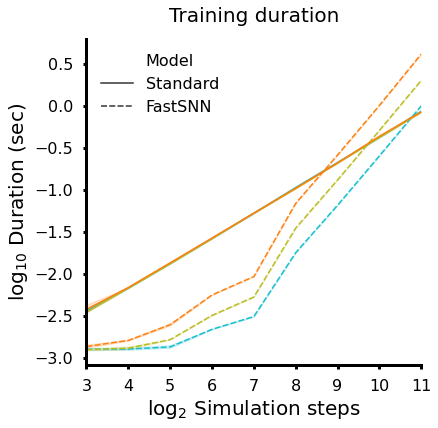

In [48]:
def plot_durations(durations_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    plot(ax, "$\\log_2$ Simulation steps", "$\\log_{10}$ Duration (sec)", "Training duration")
    sns.lineplot(data=durations_df, x="t_len", y="total_time", hue="Batch", style="Model", palette=palette, ax=ax)
    ax.margins(x=0)
    ax.set_xscale("log")
    ax.set_xticks([8, 16, 32, 64, 128, 256, 512, 1024, 2048])
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    ax.get_xaxis().set_tick_params(which='minor', size=0)
    ax.get_xaxis().set_tick_params(which='minor', width=0) 
    current_handles, current_labels = ax.get_legend_handles_labels()
    for i in range(4):
        del current_handles[0]
        del current_labels[0]
    ax.legend(current_handles, current_labels, loc="upper left", fontsize=16, title_fontsize=16, frameon=False)
    
durations_df = benchmark_query.get_durations()
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_durations(durations_df, fig, fig_spec[0, 0])

## Plot total speedup

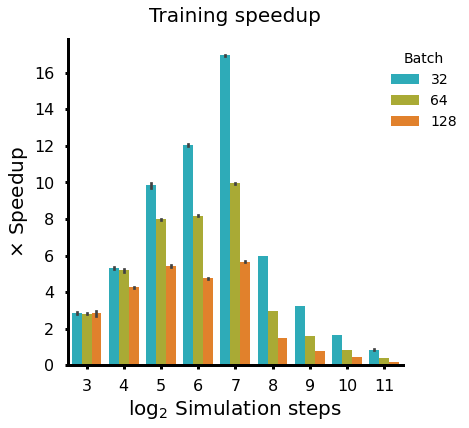

In [19]:
def plot_total_speedups(speedups_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    sns.barplot(data=speedups_df, x="t_len", y="total_speedup", hue="batch", palette=palette, ax=ax)
    plot(ax, "$\\log_2$ Simulation steps", "$\\times$ Speedup", "Training speedup")
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    ax.legend(loc="upper right", title="Batch", fontsize=14, title_fontsize=14, frameon=False, bbox_to_anchor=(1.2, 1))
    
speedups_df = benchmark_query.get_speedups(units=200).reset_index()
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_total_speedups(speedups_df, fig, fig_spec[0, 0])

## Plot forward speedup

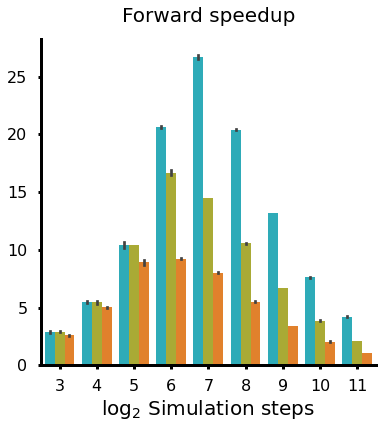

In [20]:
def plot_forward_speedups(speedups_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    sns.barplot(data=speedups_df, x="t_len", y="forward_speedup", hue="batch", palette=palette, ax=ax)
    plot(ax, "$\\log_2$ Simulation steps", None, "Forward speedup")
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    ax.legend().set_visible(False)
    
speedups_df = benchmark_query.get_speedups(units=200).reset_index()
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_forward_speedups(speedups_df, fig, fig_spec[0, 0])

## Plot forward vs backward pass speedup

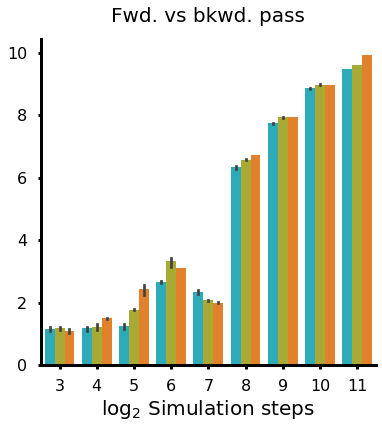

In [21]:
def plot_forward_vs_backward_speedup(forward_vs_backward_speedup_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    sns.barplot(data=forward_vs_backward_speedup_df, x="t_len", y="relative_speedup", hue="Batch", palette=palette, ax=ax)
    plot(ax, "$\\log_2$ Simulation steps", None, "Fwd. vs bkwd. pass")
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    # ax.legend(loc="upper left", title="Batch", fontsize=14, title_fontsize=14, frameon=False)
    ax.legend().set_visible(False)
    
forward_vs_backward_speedup_df = benchmark_query.get_forward_vs_backward_speedup()
        
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_forward_vs_backward_speedup(forward_vs_backward_speedup_df, fig, fig_spec[0, 0])


## Plot relative speedup

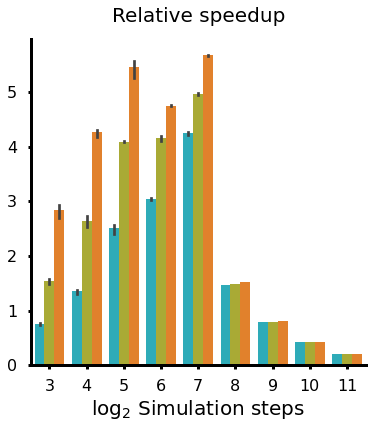

In [22]:
def plot_relative_speedups(relative_speedup_df, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    sns.barplot(data=relative_speedup_df, x="t_len", y="speedup", hue="Batch", palette=palette, ax=ax)
    plot(ax, "$\\log_2$ Simulation steps", None, "Relative speedup")
    ax.set_xticklabels([3, 4, 5, 6, 7, 8, 9, 10, 11])
    # ax.legend(loc="upper left", title="Batch", fontsize=14, title_fontsize=14, frameon=False)
    ax.legend().set_visible(False)
    
relative_speedup_df = benchmark_query.get_relative_speedups(units=200, target_batch=128)
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_relative_speedups(relative_speedup_df, fig, fig_spec[0, 0])

## Omnipotent plot

In [23]:
def plot_letter(letter, fig_spec, scale=1):
    shift = 0.2
    fontsize = 25
    ax = plt.Subplot(fig, fig_spec)
    ax.text(-shift/scale, 1.2, letter, horizontalalignment="right", verticalalignment="top", transform=ax.transData, fontweight="bold", fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.add_subplot(ax)

3.8740588284010435
5
-5.362156641130951
[-5, -4, -3, -2, -1, 0, 1, 2, 3, 3.8740588284010435]
[0.03, 0.06, 0.12, 0.25, 0.5, 1, 2, 4, 8, 14.66]


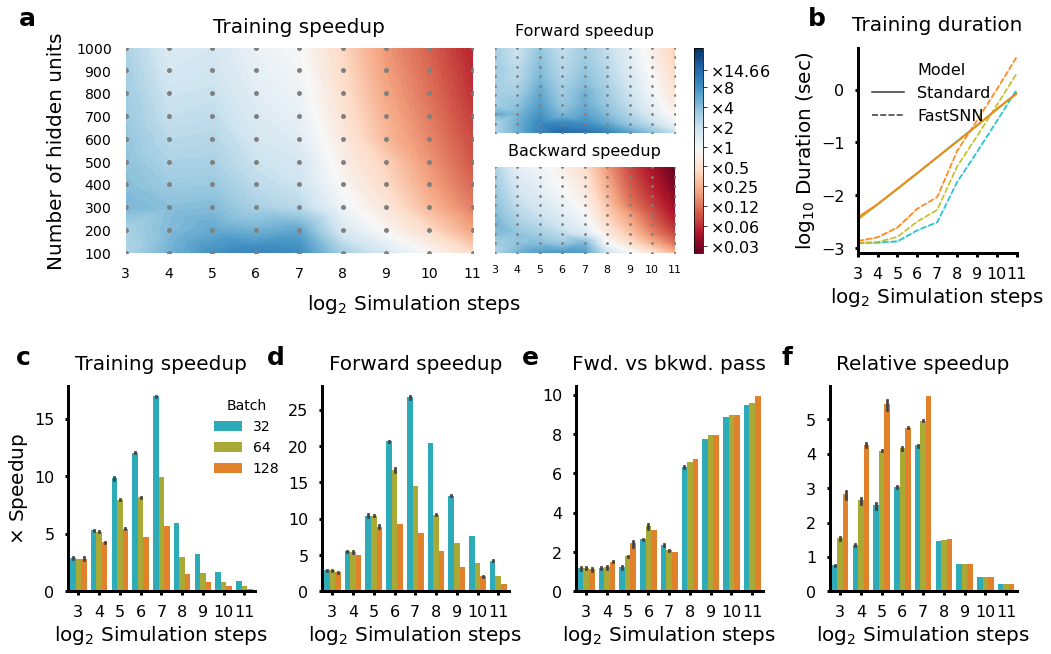

In [49]:
space = 0.65
fig = plt.figure(figsize=(17, 10))
fig_spec = gridspec.GridSpec(2, 1, hspace=space)

# Plot top row
top_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=fig_spec[0, :], wspace=0.6*space, width_ratios=[1, 0.25])
pad_top_spec = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=top_spec[0, 0], width_ratios=[0.00, 1])
plot_2d_speedups(fig, pad_top_spec[0, 1])
plot_durations(durations_df, fig, top_spec[0, 1])

# Plot bottom row
bottom_spec = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=fig_spec[1, :], wspace=0.36)
plot_total_speedups(speedups_df, fig, bottom_spec[0, 0])
plot_forward_speedups(speedups_df, fig, bottom_spec[0, 1])
plot_forward_vs_backward_speedup(forward_vs_backward_speedup_df, fig, bottom_spec[0, 2])
plot_relative_speedups(relative_speedup_df, fig, bottom_spec[0, 3])

plot_letter("a", top_spec[0, 0], scale=4)
plot_letter("b", top_spec[0, 1])
plot_letter("c", bottom_spec[0, 0])
plot_letter("d", bottom_spec[0, 1])
plot_letter("e", bottom_spec[0, 2])
plot_letter("f", bottom_spec[0, 3])